In [2]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle competitions download -c titanic
! unzip titanic.zip



mkdir: cannot create directory ‘/root/.kaggle’: File exists
  0% 0.00/34.1k [00:00<?, ?B/s]
100% 34.1k/34.1k [00:00<00:00, 20.5MB/s]
Archive:  titanic.zip
  inflating: gender_submission.csv   
  inflating: test.csv                
  inflating: train.csv               


In [58]:
#Main libraries to analysis and visualizations
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns

#--------------------------------------------------------
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix
from sklearn import model_selection
%matplotlib inline

In [4]:
train_path = "/content/train.csv"
test_path = "/content/test.csv"

In [5]:
#Create a DataFrame for both train and test sets
train_data = pd.read_csv(train_path)
test_data = pd.read_csv(test_path)

In [6]:
#Create a copy to play with and group both dataframes to clean in one
dummy_data = train_data.copy()
both_sets = [train_data, test_data]

In [7]:
#Let's check the data
train_data.head(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [8]:
#We have little data to work with
print(train_data.shape)
print(test_data.shape)

(891, 12)
(418, 11)


In [9]:
#Let's check the general info, we have some nulls in age
#a lot of nulls in cabin and just 2 in embarked
print(train_data.info())
print("-"*40)
print(test_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
None
----------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Pass

In [10]:
#38% of the passengers survived
#Parch and SibSp have high var
train_data.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


### Data analysis
- Check variables distribution and correlation
- Decide how to fill nulls
- Delete useless data

In [11]:
#Id is not usefull, assigned randomly so we can´t extract information from it
dummy_data.drop("PassengerId", axis = 1, inplace = True)

In [12]:
#Cabin has much more nulls than data for now let's drop it
dummy_data.drop("Cabin", axis = 1, inplace = True)

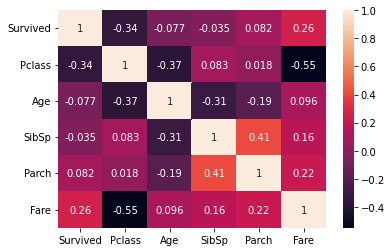

In [22]:
#Check correlation between variables
#As we can see there is high corr with Parch and SibSp
#so combining them makes even more sense
sns.heatmap(dummy_data.corr(), annot = True)
plt.show()

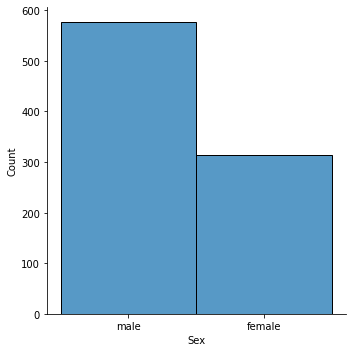

male      577
female    314
Name: Sex, dtype: int64

In [13]:
#More males than females
sns.displot(dummy_data["Sex"])
plt.show()
dummy_data["Sex"].value_counts()

In [14]:
#Check survival rate per sex is really high
dummy_data[["Survived", "Sex"]].groupby("Sex").mean()

,Survived
Sex,
female,0.742038
male,0.188908


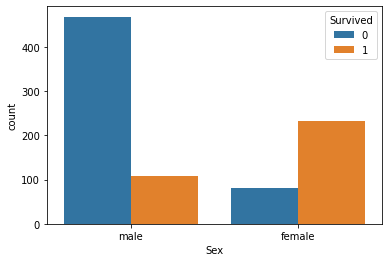

In [15]:
#Here we can see the difference between survival rate in sex
sns.countplot(x = "Sex", data = dummy_data, hue = "Survived")
plt.show()

In [16]:
#Now let's explore age attribute, it has some nulls but as we saw 
#is not high std so first let's fill those with mean +/- 2 std randomly
dummy_data["Age_cat"] = pd.qcut(dummy_data["Age"], q = 4)

In [17]:
#Here how it looks
dummy_data[["Age_cat", "Age"]].head()

,Age_cat,Age
0,"(20.125, 28.0]",22.0
1,"(28.0, 38.0]",38.0
2,"(20.125, 28.0]",26.0
3,"(28.0, 38.0]",35.0
4,"(28.0, 38.0]",35.0


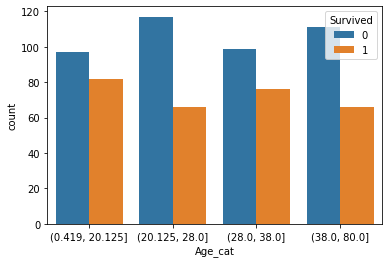

In [18]:
#Check age survival rate
sns.countplot(x = "Age_cat", data = dummy_data, hue = "Survived")
plt.show()

In [19]:
#Here we can see the survival rate per cattegorie, I was expecting that
#younger people had higher survival rate but it is not the case
dummy_data[["Age_cat", "Survived"]].groupby("Age_cat").mean()

,Survived
Age_cat,
"(0.419, 20.125]",0.458101
"(20.125, 28.0]",0.360656
"(28.0, 38.0]",0.434286
"(38.0, 80.0]",0.372881


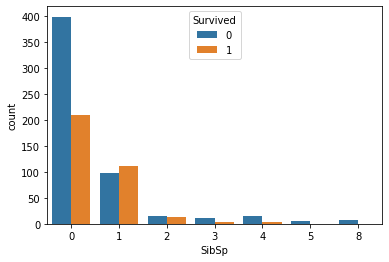

In [20]:
#As we can see Sibsp and Parch have really commond distribution
#and make sense to cobine them in a Total_family attribute
sns.countplot(x = "SibSp", data = dummy_data, hue = "Survived")
plt.show()

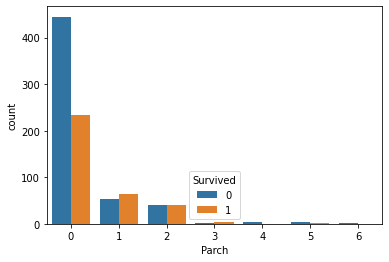

In [21]:
sns.countplot(x = "Parch", data = dummy_data, hue = "Survived")
plt.show()

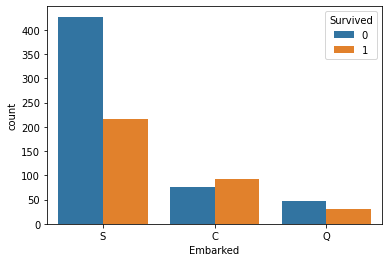

In [23]:
#Analysis of embarked
sns.countplot(x = "Embarked", data = dummy_data, hue = "Survived")
plt.show()

In [24]:
#Most people emarked in S port
dummy_data[["Embarked", "Survived"]].groupby("Embarked").count()

,Survived
Embarked,
C,168
Q,77
S,644


In [25]:
#As we can see there is clearly a difference in survival rate 
dummy_data[["Embarked", "Survived"]].groupby("Embarked").mean()

,Survived
Embarked,
C,0.553571
Q,0.389610
S,0.336957


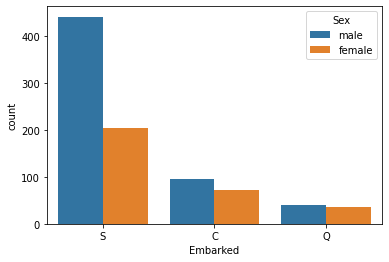

In [26]:
#Check the proportion of male/female per port
sns.countplot(x = "Embarked", data = dummy_data, hue = "Sex")
plt.show()

In [27]:
#Here we can see than C has the higher survival rate in general
dummy_data[["Embarked","Sex","Survived"]].groupby(["Sex","Embarked"]).mean()

Survived
Sex    Embarked          
female C         0.876712
       Q         0.750000
       S         0.689655
male   C         0.305263
       Q         0.073171
       S         0.174603

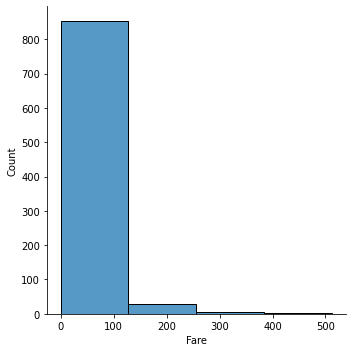

In [28]:
#Now we check Fare and Pclass
sns.displot(dummy_data["Fare"], bins = 4)
plt.show()

In [29]:
#Some people spend a lot, let's create Fare bins
dummy_data["Fare_cat"] = pd.qcut(dummy_data["Fare"], q = 6)

In [30]:
#Here we can see the intervals
dummy_data.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Age_cat,Fare_cat
0,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S,"(20.125, 28.0]","(-0.001, 7.775]"
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C,"(28.0, 38.0]","(52.369, 512.329]"
2,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S,"(20.125, 28.0]","(7.775, 8.662]"
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,S,"(28.0, 38.0]","(52.369, 512.329]"
4,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,S,"(28.0, 38.0]","(7.775, 8.662]"


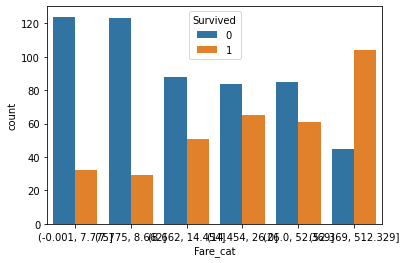

In [31]:
#Check survival rate in fare categories
sns.countplot(x = "Fare_cat", data = dummy_data, hue = "Survived")
plt.show()

In [32]:
#As we saw in the heat map there is a high positive correlation 
#between fare and survival rate
dummy_data[["Survived", "Fare_cat"]].groupby("Fare_cat").mean()

,Survived
Fare_cat,
"(-0.001, 7.775]",0.205128
"(7.775, 8.662]",0.190789
"(8.662, 14.454]",0.366906
"(14.454, 26.0]",0.436242
"(26.0, 52.369]",0.417808
"(52.369, 512.329]",0.697987


In [33]:
#Let's check if this has something to do with the sex
#ex : More females spend a lot or males in general are in a 
#lower fare categorie
fare_sex = dummy_data[["Fare","Sex"]].groupby("Sex")
mean_fare_sex = fare_sex.mean()
std_fare_sex = fare_sex.std()

In [34]:
#In general female spent more than male
#so maybe the reason high fare has a strong correlation with
#survival rate is because females in general spent more
print("-----------mean")
print(mean_fare_sex)
print("-----------std")
print(std_fare_sex)

-----------mean
             Fare
Sex              
female  44.479818
male    25.523893
-----------std
             Fare
Sex              
female  57.997698
male    43.138263


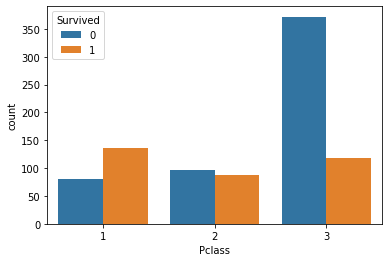

In [35]:
#Check Pclass
sns.countplot(x = "Pclass", data = dummy_data, hue = "Survived")
plt.show()

In [36]:
#As we saw in heat map Pclass is highly correlated with survival rate
dummy_data[["Pclass","Survived"]].groupby("Pclass").mean()

,Survived
Pclass,
1,0.629630
2,0.472826
3,0.242363


In [37]:
#Check survival rate of Pclass with sex
dummy_data[["Pclass","Survived","Sex"]].groupby(["Pclass","Sex"]).mean()

Survived
Pclass Sex             
1      female  0.968085
       male    0.368852
2      female  0.921053
       male    0.157407
3      female  0.500000
       male    0.135447

## What we'll do.
Based on the analysis.
- Fill nan in age with mean +/- two std.
- Drop id because it's random then we can't extract information.
- Drop cabin for now, a lot of nulls.
- Fill embarked with the mode.
- Fill two missing values in fare(test set) with mean.
- Create categories for Age and Fare.

In [38]:
print(train_data.info())
print("-"*40)
print(test_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
None
----------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Pass

In [39]:
class GeneralTransformer(BaseEstimator, TransformerMixin):
#General Transformer class created to save some time
  def __init__(self):
    pass
        
  def fit(self, X, y = None):
    return self
  
  def transform(self, X, y = None):
    return X

In [40]:
class NullReplacer(GeneralTransformer):
  '''
  NullReplacer is a class to handle missing values 
  
  Attributes : 
    dict_status (dict) : The key is the name of the column
    and the value is a boolean if True then NullReplacer
    will handle missing values in that column.
  '''  
  def __init__(self,fill_dict_status):
    self.fill_dict_status = fill_dict_status

  def age_generator(self,X):
    '''
    Generate a random age between mean and
    +/- 2 standar deviations 
    
    Args:
      X (DataFrame): Where the age column is
    
    Returns : 
      random_age (float) : A random age.
    '''
    ages = X["Age"]
    mean_age = ages.mean()
    std_age = ages.std()
    random_number = np.random.uniform(-2,2)
    random_age = random_number * mean_age
    return random_age
  
  def fill_age(self,X):
    '''
    Iterate over null values in age and call age
    generator to fill those missing values.
    '''
    condition = X["Age"].isnull()
    index = X["Age"][condition].index
    for idx in index:
      X.loc[index, "Age"] = self.age_generator(X = X)
    return X

  def transform(self, X, y = None):
    X_copy = X.copy()
    
    if self.fill_dict_status["Age"] :
      X_copy = self.fill_age(X = X_copy)
    
    return X_copy

In [41]:
class IntervalGenerator(GeneralTransformer):
  '''
  Generate intervals for non categorical data
  
  Args :
    generate_interval_dict (dict):Key is the name of column
    to generate interval, value is a boolean if True then
    apply the transformation.
  '''  
  def __init__(self,generate_interval_dict):
    self.generate_interval_dict = generate_interval_dict

  def generate_age_intervals(self,X, cuts = 4):
    '''
    For age I will implement a qcut this ensures
    that the same number of people is each interval
    Args:
      X(DataFrame) : Where the column is

    Returns :
     X(DataFrame) : With the transformatio apply
    '''
    X["Age_interval"] = pd.qcut(X["Age"], q = cuts)
    return X 

  def generate_fare_intervals(self,X,cuts = 4):
    '''
    For fare I will implement a cut this will 
    reflects that some people spent a lot
    Args:
      X(DataFrame) : Where the column is

    Returns :
    X(DataFrame) : With the transformatio apply
    '''
    X["Fare_interval"] = pd.cut(X["Fare"], bins = cuts)
    return X
    
  def transform(self, X, y = None):
    '''
    Check wich condition is True to apply the transformation
    '''
    X_copy = X.copy()    
    if self.generate_interval_dict["Fare"]:
      X_copy = self.generate_fare_intervals(X = X, cuts = 4)

    if self.generate_interval_dict["Age"]:
      X_copy = self.generate_age_intervals(X = X, cuts = 4)

    return X_copy

In [42]:
class AttrDropper(GeneralTransformer):
  '''
  Drop an attribute

  Args:
    columns(list): list with the names of columns to drop
  '''
  def __init__(self,columns):
    self.columns = columns

  def transform(self,X,y = None):
    '''
    Drop the columns

    Args:
      X(DataFrame): DataFrame to drop columns

    Returns:
    X_copy(DataFrane): DataFrame without the colums
    '''
    X_copy = X.copy()
    X_copy.drop(self.columns, axis = 1, inplace = True)
    return X_copy

In [43]:
class AttrAdder(GeneralTransformer):
  '''
  Add or transform attributes
  
  Args:
    create_family (bool): If true then add family
  '''
  def __init__(self,create_family = False):
    self.create_family = create_family

  def transform(self,X,y=None):
    '''
    Check if condition is True and apply transformation
    '''
    X_copy = X.copy()
    if self.create_family:
      X_copy["Family"] = X["SibSp"] + X["Parch"]
    return X_copy

In [44]:
#Let's fill the null fare in test set that is only one
test_data["Fare"].fillna(test_data["Fare"].mean(), inplace = True)

In [45]:
#Do the same with the two missing values in embarked on train_set
train_data["Embarked"].fillna("S", inplace = True)

In [46]:
print(train_data.info())
print(test_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     891 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pcl

In [47]:
#Define the first pipeline steps
age_dict = {"Age":True}
interval_dict = {"Fare":True, "Age":True}
drop_columns = ["PassengerId", "Cabin","Age","Fare",
                "SibSp","Parch","Name","Ticket","Survived"]
steps = [
    ("Handle missing values", NullReplacer(age_dict)),
    ("Generate intervals", IntervalGenerator(interval_dict)),
    ("Create family attribute", AttrAdder(create_family = True)),
    ("Drop columns", AttrDropper(drop_columns))
]

In [48]:
#Create an instance of the pipeline
cleaning_pipeline = Pipeline(steps = steps)

In [49]:
dummy_data = train_data.head(40)
#Use the pipeline
labels = train_data["Survived"]
#This is what the cleanin pipeline does
dummy_clean_data = cleaning_pipeline.fit_transform(dummy_data)

In [50]:
#Here we can see an example 
dummy_clean_data.head()

,Pclass,Sex,Embarked,Fare_interval,Age_interval,Family
0,3,male,S,"(6.969, 71.169]","(19.75, 35.0]",1
1,1,female,C,"(71.169, 135.112]","(35.132, 66.0]",1
2,3,female,S,"(6.969, 71.169]","(19.75, 35.0]",0
3,1,female,S,"(6.969, 71.169]","(19.75, 35.0]",1
4,3,male,S,"(6.969, 71.169]","(19.75, 35.0]",0


In [51]:
#Segment columns for second tranformation
features_to_encode = "Sex Embarked Fare_interval Age_interval".split(" ")
numerical_features = "Pclass Family".split(" ")

In [52]:
#Create an instance of one hot encoding and define the steps
categorical_transformer = OneHotEncoder()
steps = [("cat one hot encode", categorical_transformer,features_to_encode),
         ("Don't transform",GeneralTransformer(), numerical_features)]
cat_pipeline = ColumnTransformer(steps)

In [53]:
#Create a function to transform data to be ready for model
to_model_transform = lambda x : cat_pipeline.fit_transform(
    cleaning_pipeline.transform(x)
)

In [54]:
#Apply the transformation
ready_data = to_model_transform(train_data)

In [55]:
#Create different models to compare
RF_c = RandomForestClassifier()
XGB_c = XGBClassifier()
Ada_c = AdaBoostClassifier()
gradient_c = GradientBoostingClassifier()
model_names = []
models = [RF_c, XGB_c,Ada_c,gradient_c]
score_mean = []

In [56]:
#Train and check score
for model in models:
  score = cross_val_score(model,ready_data,labels,cv = 3)
  score_mean.append(score.mean())
  model_names.append(model.__class__.__name__)
model_score = dict(zip(model_names,score_mean))
model_score

{'AdaBoostClassifier': 0.7934904601571269,
 'GradientBoostingClassifier': 0.7923681257014591,
 'RandomForestClassifier': 0.7710437710437711,
 'XGBClassifier': 0.8002244668911335}

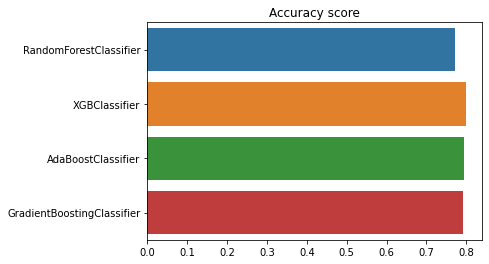

In [57]:
#Here we can see the accuracy of each model
sns.barplot(y = model_names, x  = score_mean)
plt.title("Accuracy score")
plt.show()

In [60]:
#Fit the model and save predictions
XGB_c.fit(ready_data, labels)
predictions = XGB_c.predict(ready_data)

In [73]:
#Here we compute the confusion matrix
cfm = confusion_matrix(predictions, labels)
normalized = cfm/ np.sum(cfm)

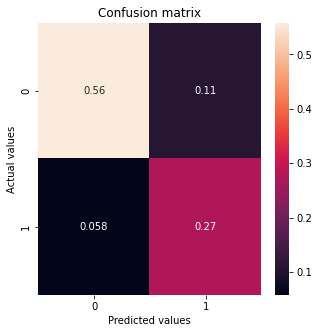

In [75]:
#Plot the confusion matrix
fig, ax = plt.subplots(figsize = (5,5))
sns.heatmap(normalized, annot = True, ax = ax)
ax.set_xlabel("Predicted values")
ax.set_ylabel("Actual values")
ax.set_title("Confusion matrix")
plt.show()

In [82]:
accuracy = round(normalized[0][0] + normalized[1][1],3)
cv_acc = round(model_score["XGBClassifier"],3)
print(f"The accuracy of the model is {accuracy} on train data and the mean in CV is {cv_acc}")

The accuracy of the model is 0.832 on train data and the mean in CV is 0.8
